<a href="https://colab.research.google.com/github/bocekci/merve/blob/main/tf_flowers_train_tfrecord.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [96]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras import layers

In [63]:
print(tf.__version__)

2.15.0


In [66]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive).with_suffix('')


pathlib kütüphanesinde with_suffix('') yöntemi, bir dosya yolundaki uzantıyı (suffix) kaldırmak için kullanılır.







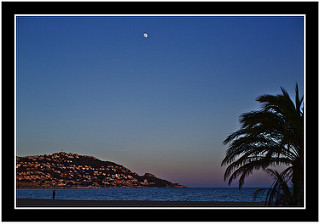

In [67]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

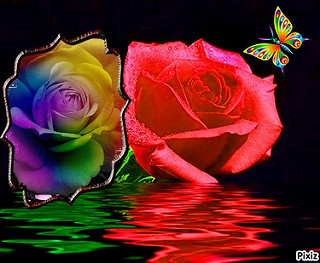

In [68]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

PIL.Image.open() bir dosya yolunu string olarak bekler.PIL.Image.open(str(roses[..]))

In [69]:
batch_size = 32
img_height = 180
img_width = 180

validation_split Veri kümesini eğitim ve doğrulama kumelerine bölmek için kullanılır yuzde olarak alır

In [70]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [71]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [72]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


veri kümesindeki sınıf adlarını içeren bir liste olarak tanımlanır.

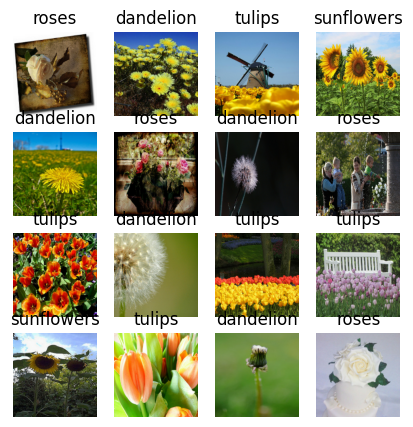

In [73]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [74]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


 her bir görüntü 180x180 piksel boyutunda ve 3 renk kanalına sahip Bu, 32 adet etiketi içeren bir tensör olduğunu gösterir

bu kod train _ds veri kümesinden bir yığını images ve lables çifti olarak alır image_batch ve labels_batch değişkenlerine bu yığını atar ve sonra bu yığının şekillerini (shape) yazdırır.Bu, modelin eğitirken veri kümesindeki verilerin nasıl göründüğünü  modelinize doğru şekilde giriş verilerini sağlamak için gereken ön işlemlere yardımcı olabilir.

In [75]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [76]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.96902645


In [77]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Bu yöntemler, veri kümesinin diskten veri yükleme işlemlerinden kaynaklanan gecikmeleri azaltarak model eğitimini hızlandırır.

In [98]:
num_classes = 5
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [79]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [97]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/2
92/92 [==============================] - ETA: 0s - loss: 0.3287 - accuracy: 0.9020

InvalidArgumentError: Graph execution error:

Detected at node DecodeJpeg defined at (most recent call last):
<stack traces unavailable>
Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node DecodeJpeg}}]]
	 [[IteratorGetNext]] [Op:__inference_test_function_13959]

epoch görüntünün kaç kez işleneceği anlamına gelmektedir .

In [82]:
import zipfile
import os

zip_path = "/content/archive (10).zip"
extract_dir = "/content/extracted_files"

# Zip dosyasını aç
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Açılan dosyaların listesini al
file_list = []
for root, dirs, files in os.walk(extract_dir):
    for file in files:
        file_list.append(os.path.join(root, file))

# Elde edilen dosya listesini kullanarak tf.data.Dataset oluştur
file_list_ds = tf.data.Dataset.from_tensor_slices(file_list)
image_count = len(file_list)


In [83]:
for f in file_list_ds.take(5):
  print(f.numpy())

b'/content/extracted_files/LICENSE.txt'
b'/content/extracted_files/sample_submission.csv'
b'/content/extracted_files/Testing_set_flower.csv'
b'/content/extracted_files/test/Image_253.jpg'
b'/content/extracted_files/test/Image_283.jpg'


In [84]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


Veri kümesini eğitim ve doğrulama kümelerine ayırın:

In [85]:
val_size = int(image_count * 0.2)
train_ds = file_list_ds.skip(val_size)
val_ds = file_list_ds.take(val_size)

bu kısımda val_ds ve train_ds veri kümesinin uzunluğunu yazdırmıs oldum

In [86]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2939
734


Bir dosya yolunu bir (img, label) çiftine dönüştüren kısa bir fonksiyon

In [87]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  one_hot = parts[-2] == class_names
  return tf.argmax(one_hot)

In [88]:
def decode_img(img):
  img = tf.io.decode_jpeg(img, channels=3)
  return tf.image.resize(img, [img_height, img_width])

In [89]:
def process_path(file_path):
  label = get_label(file_path)
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [90]:
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [91]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  0


In [92]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

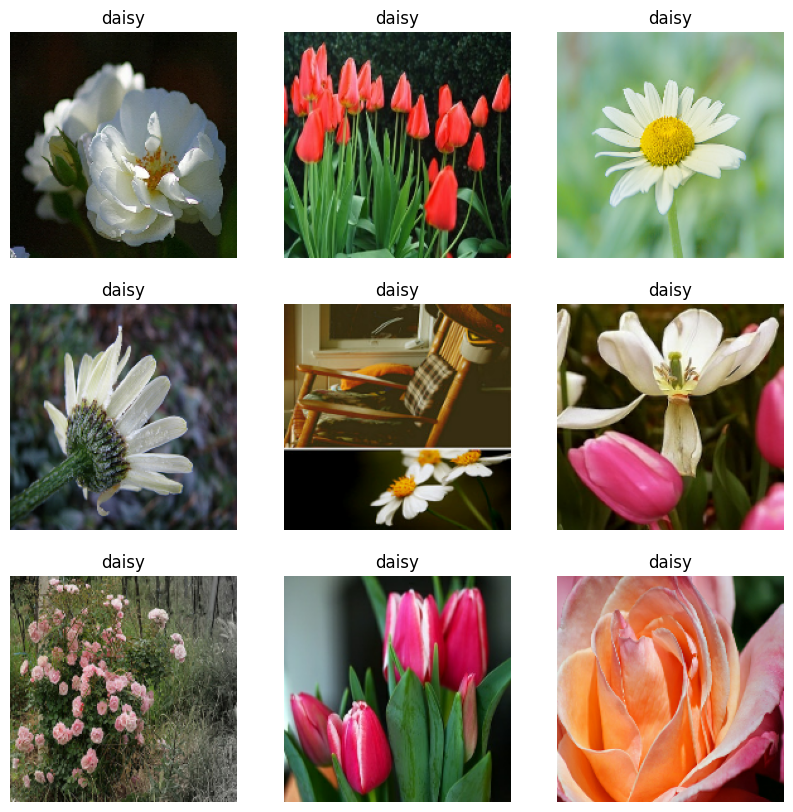

In [93]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [94]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [95]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 121s 1s/step - loss: 0.7524 - accuracy: 0.8513 - val_loss: 8.1777 - val_accuracy: 0.2643
Epoch 2/3
92/92 [==============================] - 110s 1s/step - loss: 0.3231 - accuracy: 0.8870 - val_loss: 7.7157 - val_accuracy: 0.3025
Epoch 3/3
92/92 [==============================] - 112s 1s/step - loss: 0.4305 - accuracy: 0.8448 - val_loss: 6.8873 - val_accuracy: 0.2888
